### Train and save a model

In [1]:
import pickle
import sys

# adapt paths
sys.path.append("/home/cctrotte/krauthammer/eustar_clean/benchmark_VAE/")
sys.path.append("/home/cctrotte/krauthammer/eustar_clean/benchmark_VAE/src/")


from pythae.trainers import BaseTrainerConfig
from pythae.pipelines.training import TrainingPipeline
from pythae.models import BetaVAEgpCondInd
from pythae.models import (
    BetaVAEgpCondIndConfig,
)
from pythae.models.beta_vae_gp.encoder_decoder import (
    Indep_MLP_Decoder,
    Guidance_Classifier,
    LSTM_Encoder,
    LSTM_Retrodiction_Decoder,
)

from pythae.ssc.utils import (
    load_cv,
    get_classifier_config,
    remove_short_samples,
)

from pythae.models.beta_vae_gp.classifier_config import (
    EncoderDecoderConfig,
    PriorLatentConfig,
    DecoderConfig,
)
from pythae.models.beta_vae_gp.prior_latent import PriorLatent

import numpy as np
import torch
import random

from pythae.ssc.plots import plot_losses


In [2]:
seed = 0
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
device = "cuda" if torch.cuda.is_available() else "cpu"

# adapt path
data_path = "/home/cctrotte/krauthammer/eustar_clean/fake_data/processed/"
name = "_ml4h"

# load bodies and cohorts, they have to be generate first by running the ssc/create_cv.py script
with open(data_path + "bodies_" + name + ".pkl", "rb") as file:
    bodies = pickle.load(file)
with open(data_path + "cohorts_" + name + ".pkl", "rb") as file:
    cohorts = pickle.load(file)

(
    data_train_folds,
    data_valid_folds,
    data_test_folds,
    varNames,
    varSplits,
    xyt0,
    xyt1,
) = load_cv(data_path, n_folds=2, name=name)

# variable names
var_names0 = [var.name for var in (bodies[0].variables + bodies[0].labels)]
var_weights0 = [
    var.class_weight_norm for var in (bodies[0].variables + bodies[0].labels)
]

names_x0 = [vN for i, vN in enumerate(var_names0) if xyt0[i] == "x"]
names_y0 = [vN for i, vN in enumerate(var_names0) if xyt0[i] == "y"]
weights_x0 = [vW for i, vW in enumerate(var_weights0) if xyt0[i] == "x"]
weights_y0 = [vW for i, vW in enumerate(var_weights0) if xyt0[i] == "y"]

kinds_x0 = [
    var.kind
    for var in (bodies[0].variables + bodies[0].labels)
    for nx in names_x0
    if var.name == nx
]
kinds_y0 = [
    var.kind
    for var in (bodies[0].variables + bodies[0].labels)
    for nx in names_y0
    if var.name == nx
]
splits_x0 = [vN for i, vN in enumerate(varSplits) if xyt0[i] == "x"]
splits_y0 = [vN for i, vN in enumerate(varSplits) if xyt0[i] == "y"]
splits_s0 = [vN for i, vN in enumerate(varSplits) if xyt0[i] == "s"]
# remove samples of length 0 or 1
for i, (data_train, data_valid, data_test) in enumerate(
    zip(data_train_folds, data_valid_folds, data_test_folds)
):
    data_train, data_valid, data_test = remove_short_samples(
        data_train, data_valid, data_test
    )

    data_train_folds[i] = data_train
    data_valid_folds[i] = data_valid
    data_test_folds[i] = data_test

input_size = sum(splits_x0)

static_size = sum(splits_s0)
latent_dim = 21
model_name = "VAE"

params = {
    "dropout": 0.1,
    "lstm_hidden_size": 100,
    "num_lstm_layers": 1,
    "hidden_dims_enc": [100, 100],
    "hidden_dims_emb_dec": [100],
    "hidden_dims_log_var_dec": [100],
    "classif_layers": [40],
}

# can be changed to train different models
sample_ = True
fixed_variance = False

# to create classifier configs. Specify each classifier name, variables to predict in y, z dimensions to use and architecture of the classifier
classifier_config = {
    "lung_inv": {
        "y_names": ["LUNG_ILD_involvement_or"],
        "z_dims": np.arange(0, 7),
        "layers": params["classif_layers"],
        "type": "static",
    },
    "lung_stage": {
        "y_names": ["LUNG_ILD_stage_or"],
        "z_dims": np.arange(0, 7),
        "layers": params["classif_layers"],
        "type": "static",
    },
    "heart_inv": {
        "y_names": ["HEART_involvement_or"],
        "z_dims": np.arange(7, 14),
        "layers": params["classif_layers"],
        "type": "static",
    },
    "heart_stage": {
        "y_names": ["HEART_stage_or"],
        "z_dims": np.arange(7, 14),
        "layers": params["classif_layers"],
        "type": "static",
    },
    "arthritis_inv": {
        "y_names": ["ARTHRITIS_involvement_or"],
        "z_dims": np.arange(14, 21),
        "layers": params["classif_layers"],
        "type": "static",
    },
    "arthritis_stage": {
        "y_names": ["ARTHRITIS_stage_or"],
        "z_dims": np.arange(14, 21),
        "layers": params["classif_layers"],
        "type": "static",
    },
}
# weights for the different losses
beta = 0.01
w_class = {
    "lung_inv": 0.2,
    "lung_stage": 0.2,
    "heart_inv": 0.2,
    "heart_stage": 0.2,
    "arthritis_inv": 0.2,
    "arthritis_stage": 0.2,
}

w_recon = 1
w_class_pred = {
    "lung_inv": 0.2,
    "lung_stage": 0.2,
    "heart_inv": 0.2,
    "heart_stage": 0.2,
    "arthritis_inv": 0.2,
    "arthritis_stage": 0.2,
}


classifier_configs = get_classifier_config(names_y0, splits_y0, classifier_config)

encoder_config = EncoderDecoderConfig.from_dict(
    {
        "input_dim": input_size + static_size,
        "output_dim": latent_dim,
        "latent_dim": latent_dim,
        "hidden_dims": params["hidden_dims_enc"],
        "cond_dim_time_input": 1,
        "lstm_": True,
        "lstm_hidden_size": params["lstm_hidden_size"],
        "num_lstm_layers": params["num_lstm_layers"],
        "device": device,
        "dropout": params["dropout"],
        "predict": True,
    }
)
decoder_config = DecoderConfig.from_dict(
    {
        "latent_dim": latent_dim,
        "output_dim": input_size,
        "fixed_variance": fixed_variance,
        "hidden_dims": [],
        "hidden_dims_emb": params["hidden_dims_emb_dec"],
        "hidden_dims_log_var": params["hidden_dims_log_var_dec"],
        "cond_dim_time_latent": 1,
        "cond_dim_static_latent": static_size,
        "lstm_": False,
        "dropout": params["dropout"],
        "device": device,
    }
)

prior_config = PriorLatentConfig.from_dict(
    {
        "input_dim": 1 + static_size,
        "latent_dim": latent_dim,
        "hidden_dims": [50],
        "device": device,
        "dropout": params["dropout"],
    }
)

to_reconstruct_x = [(name, index, True) for index, name in enumerate(names_x0)]

to_reconstruct_y = [(name, index, True) for index, name in enumerate(names_y0)]
model_config = BetaVAEgpCondIndConfig(
    input_dim=(input_size,),
    sample=sample_,
    latent_dim=latent_dim,
    w_class=w_class,
    w_recon=w_recon,
    beta=beta,
    w_class_pred=w_class_pred,
    missing_loss=True,
    latent_prior_noise_var=1,
    classifier_config=classifier_configs,
    encoder_config=encoder_config,
    decoder_config=decoder_config,
    prior_config=prior_config,
    splits_x0=splits_x0,
    kinds_x0=kinds_x0,
    splits_y0=splits_y0,
    kinds_y0=kinds_y0,
    names_x0=names_x0,
    weights_x0=weights_x0,
    weights_y0=weights_y0,
    to_reconstruct_x=to_reconstruct_x,
    to_reconstruct_y=to_reconstruct_y,
    device=device,
    predict=True,
    retrodiction=False,
    progression=False,
)

k = 0
print(f"Training on fold {k}")

output_dir = "saved_models/model_fold_" + str(k) + "/"
config = BaseTrainerConfig(
    output_dir=output_dir,
    learning_rate=1e-3,
    batch_size=100,
    num_epochs=50,
    customized=True,
)

my_encoder = LSTM_Encoder(encoder_config)

if decoder_config.lstm_:
    my_decoder = LSTM_Retrodiction_Decoder(decoder_config)
else:
    my_decoder = Indep_MLP_Decoder(decoder_config)

if prior_config is not None:
    prior_latent = PriorLatent(prior_config)
else:
    prior_latent = None

my_classifiers = [
    Guidance_Classifier(config) for config in model_config.classifier_config
]

model = BetaVAEgpCondInd(
    model_config=model_config,
    encoder=my_encoder,
    decoder=my_decoder,
    classifiers=my_classifiers,
    prior_latent=prior_latent,
)

pipeline = TrainingPipeline(training_config=config, model=model)

Training on fold 0


In [3]:
# train model
pipeline(train_data=data_train_folds[k], eval_data=data_valid_folds[k])

Using customized Base Trainer

Created saved_models/model_fold_0/ folder since did not exist.

Model passed sanity check !

Created saved_models/model_fold_0/BetaVAEgpCondInd_training_2023-09-01_15-05-16. 
Training config, checkpoints and final model will be saved here.

Successfully launched training !



Training of epoch 1/50:   0%|          | 0/7 [00:00<?, ?batch/s]

Eval of epoch 1/50:   0%|          | 0/7 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 3.4654
Train loss CV: 3.4654
Train losses: tensor([2.2133, 0.9565, 0.0063, 0.1431, 0.2829, 0.1196, 0.2863, 0.1398, 0.2788])
Train loss CE all: 0.7727 Train loss nll all: 1.1632
Train losses unw: tensor([7.8435, 0.9565, 0.6345, 0.7157, 1.4144, 0.5978, 1.4313, 0.6991, 1.3941])
Train losses pred: tensor([2.2058, 0.9538, 0.1430, 0.2829, 0.1201, 0.2870, 0.1402, 0.2788])
Train loss CE recon pred: 0.7732 Train loss nll recon pred: 1.1569
Train losses unw pred: tensor([7.2142, 0.9538, 0.7152, 1.4145, 0.6007, 1.4350, 0.7009, 1.3941])
Eval loss: 3.4679
Eval loss CV: 3.4679
Eval losses: tensor([2.2185, 0.9686, 0.0047, 0.1413, 0.2824, 0.1183, 0.2862, 0.1400, 0.2771])
Eval loss CE recon: 0.778 Eval loss nll recon: 1.183
Eval losses unw: tensor([7.6647, 0.9686, 0.4701, 0.7065, 1.4120, 0.5914, 1.4308, 0.7000, 1.3854])
Eval losses pred: tensor([2.2203, 0.9708, 0.1417, 0.2836, 0.1186, 0.2878, 0.1402, 0.2775])
Eval lo

Training of epoch 2/50:   0%|          | 0/7 [00:00<?, ?batch/s]

Eval of epoch 2/50:   0%|          | 0/7 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 3.3984
Train loss CV: 3.3984
Train losses: tensor([2.1610, 0.9229, 0.0063, 0.1380, 0.2811, 0.1163, 0.2824, 0.1394, 0.2746])
Train loss CE all: 0.7662 Train loss nll all: 1.0992
Train losses unw: tensor([7.7094, 0.9229, 0.6274, 0.6898, 1.4056, 0.5814, 1.4122, 0.6970, 1.3732])
Train losses pred: tensor([2.1583, 0.9209, 0.1385, 0.2818, 0.1174, 0.2852, 0.1396, 0.2750])
Train loss CE recon pred: 0.7658 Train loss nll recon pred: 1.0953
Train losses unw pred: tensor([7.1080, 0.9209, 0.6923, 1.4090, 0.5869, 1.4259, 0.6978, 1.3752])
Eval loss: 3.3996
Eval loss CV: 3.3996
Eval losses: tensor([2.1826, 0.9583, 0.0156, 0.1277, 0.2799, 0.1114, 0.2846, 0.1385, 0.2666])
Eval loss CE recon: 0.7789 Eval loss nll recon: 1.1601
Eval losses unw: tensor([8.5639, 0.9583, 1.5622, 0.6383, 1.3995, 0.5570, 1.4232, 0.6924, 1.3329])
Eval losses pred: tensor([2.1784, 0.9614, 0.1296, 0.2818, 0.1129, 0.2858, 0.1386, 0.2683])
Eval 

Training of epoch 3/50:   0%|          | 0/7 [00:00<?, ?batch/s]

Eval of epoch 3/50:   0%|          | 0/7 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 3.3295
Train loss CV: 3.3295
Train losses: tensor([2.1434, 0.9085, 0.0647, 0.1120, 0.2796, 0.1022, 0.2800, 0.1374, 0.2591])
Train loss CE all: 0.7634 Train loss nll all: 1.0717
Train losses unw: tensor([13.2287,  0.9085,  6.4690,  0.5601,  1.3978,  0.5109,  1.4002,  0.6870,
         1.2953])
Train losses pred: tensor([2.0941, 0.9081, 0.1164, 0.2814, 0.1055, 0.2827, 0.1375, 0.2625])
Train loss CE recon pred: 0.7636 Train loss nll recon pred: 1.0706
Train losses unw pred: tensor([6.8383, 0.9081, 0.5821, 1.4070, 0.5273, 1.4137, 0.6874, 1.3127])
Eval loss: 3.3269
Eval loss CV: 3.3269
Eval losses: tensor([2.1634, 0.9290, 0.0846, 0.1035, 0.2771, 0.0957, 0.2828, 0.1372, 0.2535])
Eval loss CE recon: 0.7722 Eval loss nll recon: 1.1054
Eval losses unw: tensor([15.1359,  0.9290,  8.4581,  0.5174,  1.3855,  0.4783,  1.4141,  0.6861,
         1.2674])
Eval losses pred: tensor([2.0973, 0.9338, 0.1086, 0.2785, 0.09

Training of epoch 4/50:   0%|          | 0/7 [00:00<?, ?batch/s]

Eval of epoch 4/50:   0%|          | 0/7 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 3.2842
Train loss CV: 3.2842
Train losses: tensor([2.1118, 0.8971, 0.0549, 0.1092, 0.2765, 0.0986, 0.2798, 0.1375, 0.2583])
Train loss CE all: 0.7615 Train loss nll all: 1.0497
Train losses unw: tensor([12.1835,  0.8971,  5.4873,  0.5461,  1.3823,  0.4929,  1.3991,  0.6875,
         1.2914])
Train losses pred: tensor([2.0683, 0.8959, 0.1136, 0.2779, 0.1022, 0.2800, 0.1377, 0.2610])
Train loss CE recon pred: 0.7617 Train loss nll recon pred: 1.047
Train losses unw pred: tensor([6.7578, 0.8959, 0.5680, 1.3893, 0.5109, 1.3999, 0.6886, 1.3051])
Eval loss: 3.2959
Eval loss CV: 3.2959
Eval losses: tensor([2.1226, 0.9199, 0.0430, 0.1095, 0.2758, 0.0964, 0.2828, 0.1377, 0.2575])
Eval loss CE recon: 0.7693 Eval loss nll recon: 1.0893
Eval losses unw: tensor([11.0225,  0.9199,  4.3043,  0.5476,  1.3788,  0.4820,  1.4138,  0.6887,
         1.2874])
Eval losses pred: tensor([2.0961, 0.9228, 0.1131, 0.2774, 0.099

Training of epoch 5/50:   0%|          | 0/7 [00:00<?, ?batch/s]

Eval of epoch 5/50:   0%|          | 0/7 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 3.2585
Train loss CV: 3.2585
Train losses: tensor([2.0966, 0.8911, 0.0628, 0.1026, 0.2765, 0.0904, 0.2798, 0.1375, 0.2559])
Train loss CE all: 0.7598 Train loss nll all: 1.0388
Train losses unw: tensor([12.8850,  0.8911,  6.2801,  0.5131,  1.3827,  0.4518,  1.3992,  0.6874,
         1.2796])
Train losses pred: tensor([2.0530, 0.8912, 0.1075, 0.2790, 0.0952, 0.2824, 0.1380, 0.2598])
Train loss CE recon pred: 0.7602 Train loss nll recon pred: 1.0385
Train losses unw pred: tensor([6.7005, 0.8912, 0.5376, 1.3949, 0.4760, 1.4121, 0.6898, 1.2990])
Eval loss: 3.2606
Eval loss CV: 3.2606
Eval losses: tensor([2.1229, 0.9133, 0.0873, 0.0942, 0.2747, 0.0803, 0.2838, 0.1374, 0.2521])
Eval loss CE recon: 0.7677 Eval loss nll recon: 1.077
Eval losses unw: tensor([15.2517,  0.9133,  8.7263,  0.4710,  1.3733,  0.4013,  1.4191,  0.6869,
         1.2604])
Eval losses pred: tensor([2.0560, 0.9184, 0.0993, 0.2766, 0.085

Training of epoch 6/50:   0%|          | 0/7 [00:00<?, ?batch/s]

Eval of epoch 6/50:   0%|          | 0/7 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 3.2331
Train loss CV: 3.2331
Train losses: tensor([2.0868, 0.8876, 0.0717, 0.0966, 0.2767, 0.0812, 0.2813, 0.1372, 0.2544])
Train loss CE all: 0.7583 Train loss nll all: 1.033
Train losses unw: tensor([13.6994,  0.8876,  7.1746,  0.4831,  1.3834,  0.4061,  1.4067,  0.6858,
         1.2720])
Train losses pred: tensor([2.0350, 0.8887, 0.1019, 0.2770, 0.0872, 0.2842, 0.1373, 0.2589])
Train loss CE recon pred: 0.7591 Train loss nll recon pred: 1.0344
Train losses unw pred: tensor([6.6202, 0.8887, 0.5095, 1.3848, 0.4359, 1.4208, 0.6863, 1.2943])
Eval loss: 3.2309
Eval loss CV: 3.2309
Eval losses: tensor([2.0895, 0.9060, 0.0570, 0.0984, 0.2741, 0.0796, 0.2839, 0.1373, 0.2531])
Eval loss CE recon: 0.7652 Eval loss nll recon: 1.0644
Eval losses unw: tensor([12.2395,  0.9060,  5.7011,  0.4922,  1.3707,  0.3981,  1.4197,  0.6863,
         1.2653])
Eval losses pred: tensor([2.0508, 0.9093, 0.1020, 0.2769, 0.084

Training of epoch 7/50:   0%|          | 0/7 [00:00<?, ?batch/s]

Eval of epoch 7/50:   0%|          | 0/7 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 3.1997
Train loss CV: 3.1997
Train losses: tensor([2.0651, 0.8830, 0.0666, 0.0955, 0.2755, 0.0759, 0.2793, 0.1368, 0.2526])
Train loss CE all: 0.7562 Train loss nll all: 1.0256
Train losses unw: tensor([13.1198,  0.8830,  6.6590,  0.4775,  1.3776,  0.3793,  1.3965,  0.6840,
         1.2630])
Train losses pred: tensor([2.0189, 0.8843, 0.1001, 0.2765, 0.0818, 0.2812, 0.1374, 0.2576])
Train loss CE recon pred: 0.7568 Train loss nll recon pred: 1.0279
Train losses unw pred: tensor([6.5572, 0.8843, 0.5006, 1.3823, 0.4092, 1.4059, 0.6871, 1.2879])
Eval loss: 3.1962
Eval loss CV: 3.1962
Eval losses: tensor([2.0768, 0.9014, 0.0739, 0.0917, 0.2728, 0.0690, 0.2823, 0.1371, 0.2487])
Eval loss CE recon: 0.7638 Eval loss nll recon: 1.0561
Eval losses unw: tensor([13.7972,  0.9014,  7.3879,  0.4587,  1.3642,  0.3448,  1.4116,  0.6853,
         1.2434])
Eval losses pred: tensor([2.0259, 0.9065, 0.0955, 0.2764, 0.07

Training of epoch 8/50:   0%|          | 0/7 [00:00<?, ?batch/s]

Eval of epoch 8/50:   0%|          | 0/7 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 3.1716
Train loss CV: 3.1716
Train losses: tensor([2.0485, 0.8791, 0.0674, 0.0919, 0.2755, 0.0700, 0.2780, 0.1362, 0.2504])
Train loss CE all: 0.7552 Train loss nll all: 1.0186
Train losses unw: tensor([13.1271,  0.8791,  6.7382,  0.4594,  1.3776,  0.3499,  1.3899,  0.6809,
         1.2520])
Train losses pred: tensor([2.0048, 0.8816, 0.0959, 0.2778, 0.0762, 0.2802, 0.1371, 0.2561])
Train loss CE recon pred: 0.7559 Train loss nll recon pred: 1.0231
Train losses unw pred: tensor([6.4974, 0.8816, 0.4796, 1.3889, 0.3809, 1.4008, 0.6853, 1.2804])
Eval loss: 3.1662
Eval loss CV: 3.1662
Eval losses: tensor([2.0532, 0.8970, 0.0614, 0.0905, 0.2719, 0.0669, 0.2810, 0.1370, 0.2475])
Eval loss CE recon: 0.7623 Eval loss nll recon: 1.0486
Eval losses unw: tensor([12.5085,  0.8970,  6.1372,  0.4527,  1.3596,  0.3347,  1.4051,  0.6849,
         1.2374])
Eval losses pred: tensor([2.0192, 0.9062, 0.0932, 0.2761, 0.07

Training of epoch 9/50:   0%|          | 0/7 [00:00<?, ?batch/s]

Eval of epoch 9/50:   0%|          | 0/7 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 3.1367
Train loss CV: 3.1367
Train losses: tensor([2.0254, 0.8743, 0.0659, 0.0876, 0.2732, 0.0648, 0.2764, 0.1364, 0.2467])
Train loss CE all: 0.7539 Train loss nll all: 1.0098
Train losses unw: tensor([12.8890,  0.8743,  6.5888,  0.4380,  1.3660,  0.3239,  1.3822,  0.6821,
         1.2337])
Train losses pred: tensor([1.9917, 0.8804, 0.0907, 0.2767, 0.0712, 0.2814, 0.1370, 0.2543])
Train loss CE recon pred: 0.7553 Train loss nll recon pred: 1.021
Train losses unw pred: tensor([6.4369, 0.8804, 0.4534, 1.3836, 0.3562, 1.4071, 0.6848, 1.2715])
Eval loss: 3.1369
Eval loss CV: 3.1369
Eval losses: tensor([2.0366, 0.8943, 0.0627, 0.0859, 0.2715, 0.0609, 0.2814, 0.1368, 0.2431])
Eval loss CE recon: 0.7618 Eval loss nll recon: 1.0432
Eval losses unw: tensor([12.5645,  0.8943,  6.2724,  0.4294,  1.3576,  0.3044,  1.4070,  0.6838,
         1.2156])
Eval losses pred: tensor([2.0086, 0.9082, 0.0879, 0.2768, 0.065

Training of epoch 10/50:   0%|          | 0/7 [00:00<?, ?batch/s]

Eval of epoch 10/50:   0%|          | 0/7 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 3.1118
Train loss CV: 3.1118
Train losses: tensor([2.0070, 0.8695, 0.0631, 0.0863, 0.2718, 0.0607, 0.2754, 0.1361, 0.2441])
Train loss CE all: 0.753 Train loss nll all: 1.0005
Train losses unw: tensor([12.5553,  0.8695,  6.3139,  0.4315,  1.3591,  0.3033,  1.3771,  0.6806,
         1.2204])
Train losses pred: tensor([1.9845, 0.8797, 0.0882, 0.2766, 0.0664, 0.2820, 0.1372, 0.2545])
Train loss CE recon pred: 0.7553 Train loss nll recon pred: 1.0196
Train losses unw pred: tensor([6.4038, 0.8797, 0.4410, 1.3829, 0.3321, 1.4099, 0.6859, 1.2723])
Eval loss: 3.1066
Eval loss CV: 3.1066
Eval losses: tensor([2.0141, 0.8891, 0.0574, 0.0848, 0.2687, 0.0587, 0.2798, 0.1363, 0.2393])
Eval loss CE recon: 0.7599 Eval loss nll recon: 1.0345
Eval losses unw: tensor([11.9634,  0.8891,  5.7365,  0.4238,  1.3436,  0.2935,  1.3989,  0.6814,
         1.1967])
Eval losses pred: tensor([2.0017, 0.9092, 0.0851, 0.2757, 0.061

Training of epoch 11/50:   0%|          | 0/7 [00:00<?, ?batch/s]

Eval of epoch 11/50:   0%|          | 0/7 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 3.0868
Train loss CV: 3.0868
Train losses: tensor([1.9915, 0.8671, 0.0615, 0.0836, 0.2706, 0.0582, 0.2750, 0.1355, 0.2400])
Train loss CE all: 0.7518 Train loss nll all: 0.9968
Train losses unw: tensor([12.3348,  0.8671,  6.1530,  0.4179,  1.3528,  0.2912,  1.3750,  0.6776,
         1.2002])
Train losses pred: tensor([1.9778, 0.8826, 0.0843, 0.2768, 0.0629, 0.2819, 0.1375, 0.2519])
Train loss CE recon pred: 0.7546 Train loss nll recon pred: 1.0265
Train losses unw pred: tensor([6.3587, 0.8826, 0.4213, 1.3842, 0.3144, 1.4095, 0.6874, 1.2594])
Eval loss: 3.078
Eval loss CV: 3.078
Eval losses: tensor([1.9912, 0.8817, 0.0518, 0.0827, 0.2680, 0.0570, 0.2784, 0.1359, 0.2357])
Eval loss CE recon: 0.7581 Eval loss nll recon: 1.0208
Eval losses unw: tensor([11.3523,  0.8817,  5.1824,  0.4133,  1.3398,  0.2851,  1.3921,  0.6796,
         1.1783])
Eval losses pred: tensor([1.9927, 0.9059, 0.0817, 0.2774, 0.0593

Training of epoch 12/50:   0%|          | 0/7 [00:00<?, ?batch/s]

Eval of epoch 12/50:   0%|          | 0/7 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 3.0551
Train loss CV: 3.0551
Train losses: tensor([1.9674, 0.8576, 0.0595, 0.0805, 0.2696, 0.0560, 0.2725, 0.1345, 0.2372])
Train loss CE all: 0.7493 Train loss nll all: 0.9794
Train losses unw: tensor([12.0618,  0.8576,  5.9528,  0.4023,  1.3479,  0.2801,  1.3623,  0.6727,
         1.1861])
Train losses pred: tensor([1.9678, 0.8801, 0.0811, 0.2783, 0.0604, 0.2798, 0.1367, 0.2515])
Train loss CE recon pred: 0.754 Train loss nll recon pred: 1.022
Train losses unw pred: tensor([6.3187, 0.8801, 0.4054, 1.3914, 0.3021, 1.3988, 0.6833, 1.2576])
Eval loss: 3.0474
Eval loss CV: 3.0474
Eval losses: tensor([1.9709, 0.8746, 0.0583, 0.0791, 0.2649, 0.0516, 0.2764, 0.1355, 0.2304])
Eval loss CE recon: 0.7557 Eval loss nll recon: 1.0083
Eval losses unw: tensor([11.8966,  0.8746,  5.8320,  0.3956,  1.3246,  0.2581,  1.3822,  0.6777,
         1.1519])
Eval losses pred: tensor([1.9843, 0.9078, 0.0780, 0.2776, 0.0543

Training of epoch 13/50:   0%|          | 0/7 [00:00<?, ?batch/s]

Eval of epoch 13/50:   0%|          | 0/7 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 3.0203
Train loss CV: 3.0203
Train losses: tensor([1.9413, 0.8497, 0.0625, 0.0778, 0.2647, 0.0517, 0.2678, 0.1343, 0.2328])
Train loss CE all: 0.7472 Train loss nll all: 0.9651
Train losses unw: tensor([12.2474,  0.8497,  6.2525,  0.3889,  1.3235,  0.2585,  1.3390,  0.6714,
         1.1638])
Train losses pred: tensor([1.9581, 0.8791, 0.0776, 0.2775, 0.0560, 0.2799, 0.1373, 0.2508])
Train loss CE recon pred: 0.7538 Train loss nll recon pred: 1.0202
Train losses unw pred: tensor([6.2740, 0.8791, 0.3879, 1.3874, 0.2798, 1.3993, 0.6866, 1.2538])
Eval loss: 3.0237
Eval loss CV: 3.0237
Eval losses: tensor([1.9523, 0.8702, 0.0600, 0.0769, 0.2613, 0.0476, 0.2739, 0.1350, 0.2273])
Eval loss CE recon: 0.754 Eval loss nll recon: 1.001
Eval losses unw: tensor([11.9822,  0.8702,  6.0018,  0.3847,  1.3064,  0.2382,  1.3696,  0.6749,
         1.1365])
Eval losses pred: tensor([1.9830, 0.9116, 0.0756, 0.2775, 0.0504

Training of epoch 14/50:   0%|          | 0/7 [00:00<?, ?batch/s]

Eval of epoch 14/50:   0%|          | 0/7 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.9993
Train loss CV: 2.9993
Train losses: tensor([1.9234, 0.8424, 0.0628, 0.0765, 0.2653, 0.0491, 0.2643, 0.1340, 0.2292])
Train loss CE all: 0.7441 Train loss nll all: 0.9529
Train losses unw: tensor([12.2088,  0.8424,  6.2750,  0.3826,  1.3263,  0.2454,  1.3215,  0.6698,
         1.1458])
Train losses pred: tensor([1.9538, 0.8779, 0.0764, 0.2793, 0.0528, 0.2802, 0.1373, 0.2498])
Train loss CE recon pred: 0.7529 Train loss nll recon pred: 1.0186
Train losses unw pred: tensor([6.2573, 0.8779, 0.3818, 1.3963, 0.2642, 1.4012, 0.6867, 1.2492])
Eval loss: 2.9961
Eval loss CV: 2.9961
Eval losses: tensor([1.9302, 0.8600, 0.0606, 0.0760, 0.2594, 0.0457, 0.2701, 0.1345, 0.2239])
Eval loss CE recon: 0.7507 Eval loss nll recon: 0.983
Eval losses unw: tensor([11.9645,  0.8600,  6.0563,  0.3799,  1.2971,  0.2285,  1.3506,  0.6726,
         1.1195])
Eval losses pred: tensor([1.9735, 0.9076, 0.0745, 0.2766, 0.048

Training of epoch 15/50:   0%|          | 0/7 [00:00<?, ?batch/s]

Eval of epoch 15/50:   0%|          | 0/7 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.9688
Train loss CV: 2.9688
Train losses: tensor([1.9009, 0.8354, 0.0677, 0.0752, 0.2583, 0.0471, 0.2577, 0.1336, 0.2260])
Train loss CE all: 0.7401 Train loss nll all: 0.9426
Train losses unw: tensor([12.5920,  0.8354,  6.7674,  0.3760,  1.2916,  0.2355,  1.2884,  0.6678,
         1.1298])
Train losses pred: tensor([1.9460, 0.8781, 0.0751, 0.2767, 0.0518, 0.2771, 0.1367, 0.2505])
Train loss CE recon pred: 0.7523 Train loss nll recon pred: 1.0196
Train losses unw pred: tensor([6.2175, 0.8781, 0.3756, 1.3836, 0.2588, 1.3854, 0.6835, 1.2526])
Eval loss: 2.9762
Eval loss CV: 2.9762
Eval losses: tensor([1.9129, 0.8530, 0.0617, 0.0761, 0.2558, 0.0450, 0.2649, 0.1343, 0.2222])
Eval loss CE recon: 0.7473 Eval loss nll recon: 0.9718
Eval losses unw: tensor([12.0143,  0.8530,  6.1702,  0.3803,  1.2788,  0.2252,  1.3244,  0.6716,
         1.1109])
Eval losses pred: tensor([1.9720, 0.9087, 0.0744, 0.2756, 0.04

Training of epoch 16/50:   0%|          | 0/7 [00:00<?, ?batch/s]

Eval of epoch 16/50:   0%|          | 0/7 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.9488
Train loss CV: 2.9488
Train losses: tensor([1.8833, 0.8292, 0.0727, 0.0752, 0.2561, 0.0448, 0.2495, 0.1338, 0.2218])
Train loss CE all: 0.7375 Train loss nll all: 0.9324
Train losses unw: tensor([13.0086,  0.8292,  7.2728,  0.3762,  1.2807,  0.2240,  1.2477,  0.6690,
         1.1091])
Train losses pred: tensor([1.9469, 0.8813, 0.0746, 0.2763, 0.0510, 0.2772, 0.1376, 0.2488])
Train loss CE recon pred: 0.7524 Train loss nll recon pred: 1.0264
Train losses unw pred: tensor([6.2090, 0.8813, 0.3731, 1.3815, 0.2549, 1.3861, 0.6879, 1.2442])
Eval loss: 2.9566
Eval loss CV: 2.9566
Eval losses: tensor([1.8932, 0.8469, 0.0621, 0.0761, 0.2529, 0.0449, 0.2568, 0.1344, 0.2192])
Eval loss CE recon: 0.7442 Eval loss nll recon: 0.9624
Eval losses unw: tensor([11.9794,  0.8469,  6.2114,  0.3804,  1.2647,  0.2243,  1.2838,  0.6718,
         1.0961])
Eval losses pred: tensor([1.9728, 0.9094, 0.0744, 0.2737, 0.04

Training of epoch 17/50:   0%|          | 0/7 [00:00<?, ?batch/s]

Eval of epoch 17/50:   0%|          | 0/7 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.923
Train loss CV: 2.923
Train losses: tensor([1.8623, 0.8245, 0.0736, 0.0736, 0.2539, 0.0441, 0.2401, 0.1334, 0.2190])
Train loss CE all: 0.7351 Train loss nll all: 0.9251
Train losses unw: tensor([13.0025,  0.8245,  7.3570,  0.3679,  1.2697,  0.2205,  1.2006,  0.6671,
         1.0952])
Train losses pred: tensor([1.9424, 0.8816, 0.0739, 0.2771, 0.0494, 0.2741, 0.1372, 0.2491])
Train loss CE recon pred: 0.7527 Train loss nll recon pred: 1.0267
Train losses unw pred: tensor([6.1854, 0.8816, 0.3694, 1.3853, 0.2471, 1.3703, 0.6859, 1.2457])
Eval loss: 2.9252
Eval loss CV: 2.9252
Eval losses: tensor([1.8647, 0.8372, 0.0637, 0.0755, 0.2499, 0.0443, 0.2460, 0.1341, 0.2139])
Eval loss CE recon: 0.7404 Eval loss nll recon: 0.946
Eval losses unw: tensor([12.0243,  0.8372,  6.3681,  0.3775,  1.2495,  0.2217,  1.2300,  0.6706,
         1.0697])
Eval losses pred: tensor([1.9658, 0.9052, 0.0740, 0.2742, 0.0470,

Training of epoch 18/50:   0%|          | 0/7 [00:00<?, ?batch/s]

Eval of epoch 18/50:   0%|          | 0/7 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.8926
Train loss CV: 2.8926
Train losses: tensor([1.8321, 0.8202, 0.0777, 0.0728, 0.2508, 0.0440, 0.2186, 0.1338, 0.2142])
Train loss CE all: 0.7294 Train loss nll all: 0.9222
Train losses unw: tensor([13.2628,  0.8202,  7.7715,  0.3639,  1.2541,  0.2202,  1.0932,  0.6688,
         1.0708])
Train losses pred: tensor([1.9441, 0.8836, 0.0734, 0.2765, 0.0496, 0.2727, 0.1381, 0.2503])
Train loss CE recon pred: 0.7498 Train loss nll recon pred: 1.0341
Train losses unw pred: tensor([6.1862, 0.8836, 0.3668, 1.3824, 0.2480, 1.3633, 0.6905, 1.2515])
Eval loss: 2.8989
Eval loss CV: 2.8989
Eval losses: tensor([1.8445, 0.8295, 0.0723, 0.0748, 0.2456, 0.0437, 0.2349, 0.1337, 0.2100])
Eval loss CE recon: 0.7361 Eval loss nll recon: 0.9346
Eval losses unw: tensor([12.7703,  0.8295,  7.2274,  0.3739,  1.2279,  0.2185,  1.1745,  0.6686,
         1.0499])
Eval losses pred: tensor([1.9557, 0.9013, 0.0733, 0.2741, 0.04

Training of epoch 19/50:   0%|          | 0/7 [00:00<?, ?batch/s]

Eval of epoch 19/50:   0%|          | 0/7 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.8497
Train loss CV: 2.8497
Train losses: tensor([1.7978, 0.8093, 0.0839, 0.0719, 0.2426, 0.0434, 0.2043, 0.1331, 0.2094])
Train loss CE all: 0.7247 Train loss nll all: 0.9045
Train losses unw: tensor([13.7215,  0.8093,  8.3892,  0.3593,  1.2128,  0.2168,  1.0215,  0.6654,
         1.0472])
Train losses pred: tensor([1.9323, 0.8805, 0.0717, 0.2756, 0.0488, 0.2678, 0.1378, 0.2503])
Train loss CE recon pred: 0.7493 Train loss nll recon pred: 1.028
Train losses unw pred: tensor([6.1398, 0.8805, 0.3585, 1.3778, 0.2439, 1.3389, 0.6888, 1.2514])
Eval loss: 2.8516
Eval loss CV: 2.8516
Eval losses: tensor([1.8031, 0.8191, 0.0806, 0.0717, 0.2375, 0.0413, 0.2166, 0.1334, 0.2028])
Eval loss CE recon: 0.7289 Eval loss nll recon: 0.9206
Eval losses unw: tensor([13.4006,  0.8191,  8.0649,  0.3587,  1.1875,  0.2065,  1.0830,  0.6671,
         1.0139])
Eval losses pred: tensor([1.9509, 0.9024, 0.0721, 0.2733, 0.044

Training of epoch 20/50:   0%|          | 0/7 [00:00<?, ?batch/s]

Eval of epoch 20/50:   0%|          | 0/7 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.7993
Train loss CV: 2.7993
Train losses: tensor([1.7584, 0.8015, 0.0895, 0.0705, 0.2306, 0.0417, 0.1862, 0.1325, 0.2060])
Train loss CE all: 0.7198 Train loss nll all: 0.8933
Train losses unw: tensor([14.0877,  0.8015,  8.9488,  0.3527,  1.1528,  0.2087,  0.9310,  0.6623,
         1.0300])
Train losses pred: tensor([1.9256, 0.8847, 0.0717, 0.2751, 0.0471, 0.2580, 0.1379, 0.2512])
Train loss CE recon pred: 0.7486 Train loss nll recon pred: 1.038
Train losses unw pred: tensor([6.0891, 0.8847, 0.3583, 1.3755, 0.2354, 1.2898, 0.6893, 1.2561])
Eval loss: 2.8262
Eval loss CV: 2.8262
Eval losses: tensor([1.7789, 0.8167, 0.0944, 0.0696, 0.2297, 0.0392, 0.1989, 0.1325, 0.1980])
Eval loss CE recon: 0.7237 Eval loss nll recon: 0.9212
Eval losses unw: tensor([14.5932,  0.8167,  9.4371,  0.3480,  1.1486,  0.1958,  0.9947,  0.6625,
         0.9898])
Eval losses pred: tensor([1.9588, 0.9116, 0.0704, 0.2735, 0.043

Training of epoch 21/50:   0%|          | 0/7 [00:00<?, ?batch/s]

Eval of epoch 21/50:   0%|          | 0/7 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.7687
Train loss CV: 2.7687
Train losses: tensor([1.7310, 0.7970, 0.0943, 0.0697, 0.2214, 0.0415, 0.1740, 0.1321, 0.2009])
Train loss CE all: 0.7125 Train loss nll all: 0.8921
Train losses unw: tensor([14.4279,  0.7970,  9.4327,  0.3486,  1.1072,  0.2077,  0.8699,  0.6605,
         1.0044])
Train losses pred: tensor([1.9218, 0.8841, 0.0732, 0.2731, 0.0476, 0.2563, 0.1379, 0.2497])
Train loss CE recon pred: 0.746 Train loss nll recon pred: 1.0395
Train losses unw pred: tensor([6.0725, 0.8841, 0.3659, 1.3656, 0.2378, 1.2814, 0.6895, 1.2483])
Eval loss: 2.7794
Eval loss CV: 2.7794
Eval losses: tensor([1.7381, 0.8067, 0.0877, 0.0693, 0.2204, 0.0402, 0.1852, 0.1328, 0.1957])
Eval loss CE recon: 0.7159 Eval loss nll recon: 0.9088
Eval losses unw: tensor([13.7961,  0.8067,  8.7712,  0.3464,  1.1018,  0.2010,  0.9260,  0.6642,
         0.9787])
Eval losses pred: tensor([1.9480, 0.9066, 0.0709, 0.2729, 0.044

Training of epoch 22/50:   0%|          | 0/7 [00:00<?, ?batch/s]

Eval of epoch 22/50:   0%|          | 0/7 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.7284
Train loss CV: 2.7284
Train losses: tensor([1.7018, 0.7893, 0.0997, 0.0688, 0.2121, 0.0411, 0.1603, 0.1322, 0.1983])
Train loss CE all: 0.7065 Train loss nll all: 0.8825
Train losses unw: tensor([14.8254,  0.7893,  9.9721,  0.3439,  1.0603,  0.2055,  0.8016,  0.6608,
         0.9917])
Train losses pred: tensor([1.9056, 0.8790, 0.0714, 0.2706, 0.0466, 0.2486, 0.1384, 0.2510])
Train loss CE recon pred: 0.7422 Train loss nll recon pred: 1.0329
Train losses unw pred: tensor([6.0119, 0.8790, 0.3568, 1.3531, 0.2332, 1.2429, 0.6918, 1.2551])
Eval loss: 2.7485
Eval loss CV: 2.7485
Eval losses: tensor([1.7153, 0.8034, 0.0885, 0.0689, 0.2119, 0.0411, 0.1754, 0.1322, 0.1938])
Eval loss CE recon: 0.7115 Eval loss nll recon: 0.9068
Eval losses unw: tensor([13.7691,  0.8034,  8.8486,  0.3447,  1.0594,  0.2057,  0.8771,  0.6612,
         0.9690])
Eval losses pred: tensor([1.9363, 0.9031, 0.0709, 0.2722, 0.04

Training of epoch 23/50:   0%|          | 0/7 [00:00<?, ?batch/s]

Eval of epoch 23/50:   0%|          | 0/7 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.6887
Train loss CV: 2.6887
Train losses: tensor([1.6734, 0.7832, 0.1051, 0.0676, 0.2016, 0.0407, 0.1501, 0.1311, 0.1940])
Train loss CE all: 0.7004 Train loss nll all: 0.8764
Train losses unw: tensor([15.2214,  0.7832, 10.5128,  0.3379,  1.0082,  0.2033,  0.7506,  0.6554,
         0.9700])
Train losses pred: tensor([1.8922, 0.8770, 0.0712, 0.2694, 0.0469, 0.2397, 0.1381, 0.2500])
Train loss CE recon pred: 0.7398 Train loss nll recon pred: 1.0313
Train losses unw pred: tensor([5.9533, 0.8770, 0.3559, 1.3469, 0.2345, 1.1987, 0.6903, 1.2499])
Eval loss: 2.7276
Eval loss CV: 2.7276
Eval losses: tensor([1.7001, 0.8001, 0.0959, 0.0675, 0.2062, 0.0404, 0.1677, 0.1321, 0.1903])
Eval loss CE recon: 0.7074 Eval loss nll recon: 0.9043
Eval losses unw: tensor([14.4147,  0.8001,  9.5941,  0.3373,  1.0309,  0.2021,  0.8383,  0.6603,
         0.9516])
Eval losses pred: tensor([1.9282, 0.9007, 0.0712, 0.2720, 0.04

Training of epoch 24/50:   0%|          | 0/7 [00:00<?, ?batch/s]

Eval of epoch 24/50:   0%|          | 0/7 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.6723
Train loss CV: 2.6723
Train losses: tensor([1.6598, 0.7818, 0.1065, 0.0674, 0.1964, 0.0406, 0.1453, 0.1312, 0.1906])
Train loss CE all: 0.696 Train loss nll all: 0.8782
Train losses unw: tensor([15.2910,  0.7818, 10.6518,  0.3368,  0.9819,  0.2029,  0.7265,  0.6562,
         0.9530])
Train losses pred: tensor([1.8895, 0.8769, 0.0722, 0.2686, 0.0464, 0.2374, 0.1381, 0.2498])
Train loss CE recon pred: 0.7366 Train loss nll recon pred: 1.0347
Train losses unw pred: tensor([5.9398, 0.8769, 0.3612, 1.3430, 0.2320, 1.1871, 0.6905, 1.2491])
Eval loss: 2.7001
Eval loss CV: 2.7001
Eval losses: tensor([1.6786, 0.7957, 0.0957, 0.0666, 0.2012, 0.0399, 0.1619, 0.1318, 0.1858])
Eval loss CE recon: 0.704 Eval loss nll recon: 0.8988
Eval losses unw: tensor([14.3012,  0.7957,  9.5695,  0.3328,  1.0062,  0.1996,  0.8093,  0.6592,
         0.9289])
Eval losses pred: tensor([1.9211, 0.8995, 0.0702, 0.2679, 0.0439

Training of epoch 25/50:   0%|          | 0/7 [00:00<?, ?batch/s]

Eval of epoch 25/50:   0%|          | 0/7 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.655
Train loss CV: 2.655
Train losses: tensor([1.6481, 0.7784, 0.1072, 0.0656, 0.1953, 0.0422, 0.1408, 0.1309, 0.1878])
Train loss CE all: 0.6945 Train loss nll all: 0.8727
Train losses unw: tensor([15.3129,  0.7784, 10.7222,  0.3279,  0.9765,  0.2108,  0.7038,  0.6545,
         0.9388])
Train losses pred: tensor([1.8804, 0.8734, 0.0713, 0.2664, 0.0481, 0.2314, 0.1388, 0.2510])
Train loss CE recon pred: 0.735 Train loss nll recon pred: 1.0291
Train losses unw pred: tensor([5.9083, 0.8734, 0.3563, 1.3321, 0.2405, 1.1570, 0.6939, 1.2550])
Eval loss: 2.6777
Eval loss CV: 2.6777
Eval losses: tensor([1.6603, 0.7917, 0.1017, 0.0654, 0.1965, 0.0384, 0.1553, 0.1311, 0.1802])
Eval loss CE recon: 0.702 Eval loss nll recon: 0.8925
Eval losses unw: tensor([14.7993,  0.7917, 10.1731,  0.3271,  0.9823,  0.1922,  0.7765,  0.6553,
         0.9012])
Eval losses pred: tensor([1.9163, 0.8989, 0.0697, 0.2663, 0.0425, 

Training of epoch 26/50:   0%|          | 0/7 [00:00<?, ?batch/s]

Eval of epoch 26/50:   0%|          | 0/7 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.631
Train loss CV: 2.631
Train losses: tensor([1.6261, 0.7720, 0.1103, 0.0650, 0.1900, 0.0406, 0.1341, 0.1300, 0.1840])
Train loss CE all: 0.6924 Train loss nll all: 0.8616
Train losses unw: tensor([15.5199,  0.7720, 11.0289,  0.3249,  0.9502,  0.2032,  0.6707,  0.6502,
         0.9198])
Train losses pred: tensor([1.8763, 0.8714, 0.0706, 0.2647, 0.0461, 0.2326, 0.1385, 0.2524])
Train loss CE recon pred: 0.7372 Train loss nll recon pred: 1.0223
Train losses unw pred: tensor([5.8961, 0.8714, 0.3532, 1.3235, 0.2304, 1.1631, 0.6924, 1.2622])
Eval loss: 2.6597
Eval loss CV: 2.6597
Eval losses: tensor([1.6507, 0.7887, 0.1053, 0.0654, 0.1939, 0.0384, 0.1500, 0.1306, 0.1784])
Eval loss CE recon: 0.6988 Eval loss nll recon: 0.89
Eval losses unw: tensor([15.1026,  0.7887, 10.5308,  0.3269,  0.9693,  0.1920,  0.7501,  0.6530,
         0.8919])
Eval losses pred: tensor([1.9062, 0.8972, 0.0698, 0.2648, 0.0426, 

Training of epoch 27/50:   0%|          | 0/7 [00:00<?, ?batch/s]

Eval of epoch 27/50:   0%|          | 0/7 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.613
Train loss CV: 2.613
Train losses: tensor([1.6164, 0.7728, 0.1120, 0.0654, 0.1871, 0.0410, 0.1275, 0.1299, 0.1806])
Train loss CE all: 0.6906 Train loss nll all: 0.8652
Train losses unw: tensor([15.6335,  0.7728, 11.2025,  0.3272,  0.9357,  0.2049,  0.6377,  0.6495,
         0.9032])
Train losses pred: tensor([1.8687, 0.8722, 0.0711, 0.2632, 0.0466, 0.2264, 0.1387, 0.2505])
Train loss CE recon pred: 0.7339 Train loss nll recon pred: 1.0277
Train losses unw pred: tensor([5.8549, 0.8722, 0.3555, 1.3159, 0.2332, 1.1322, 0.6936, 1.2523])
Eval loss: 2.6466
Eval loss CV: 2.6466
Eval losses: tensor([1.6423, 0.7885, 0.1101, 0.0641, 0.1940, 0.0382, 0.1417, 0.1300, 0.1759])
Eval loss CE recon: 0.6988 Eval loss nll recon: 0.8894
Eval losses unw: tensor([15.5132,  0.7885, 11.0058,  0.3204,  0.9700,  0.1908,  0.7084,  0.6498,
         0.8796])
Eval losses pred: tensor([1.9026, 0.8983, 0.0688, 0.2649, 0.0422

Training of epoch 28/50:   0%|          | 0/7 [00:00<?, ?batch/s]

Eval of epoch 28/50:   0%|          | 0/7 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.586
Train loss CV: 2.586
Train losses: tensor([1.5984, 0.7686, 0.1177, 0.0654, 0.1827, 0.0406, 0.1157, 0.1293, 0.1785])
Train loss CE all: 0.6887 Train loss nll all: 0.8583
Train losses unw: tensor([16.1006,  0.7686, 11.7716,  0.3269,  0.9137,  0.2028,  0.5784,  0.6463,
         0.8924])
Train losses pred: tensor([1.8596, 0.8720, 0.0702, 0.2622, 0.0465, 0.2187, 0.1390, 0.2510])
Train loss CE recon pred: 0.7351 Train loss nll recon pred: 1.026
Train losses unw pred: tensor([5.8100, 0.8720, 0.3508, 1.3112, 0.2325, 1.0937, 0.6948, 1.2550])
Eval loss: 2.6174
Eval loss CV: 2.6174
Eval losses: tensor([1.6190, 0.7848, 0.1109, 0.0644, 0.1896, 0.0386, 0.1296, 0.1286, 0.1726])
Eval loss CE recon: 0.6964 Eval loss nll recon: 0.8843
Eval losses unw: tensor([15.4913,  0.7848, 11.0899,  0.3218,  0.9479,  0.1929,  0.6479,  0.6430,
         0.8630])
Eval losses pred: tensor([1.8947, 0.8963, 0.0692, 0.2633, 0.0425,

Training of epoch 29/50:   0%|          | 0/7 [00:00<?, ?batch/s]

Eval of epoch 29/50:   0%|          | 0/7 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.5633
Train loss CV: 2.5633
Train losses: tensor([1.5794, 0.7643, 0.1226, 0.0635, 0.1797, 0.0403, 0.1082, 0.1270, 0.1739])
Train loss CE all: 0.6855 Train loss nll all: 0.8529
Train losses unw: tensor([16.4841,  0.7643, 12.2569,  0.3177,  0.8984,  0.2013,  0.5409,  0.6351,
         0.8695])
Train losses pred: tensor([1.8509, 0.8670, 0.0690, 0.2619, 0.0473, 0.2163, 0.1386, 0.2508])
Train loss CE recon pred: 0.7297 Train loss nll recon pred: 1.0215
Train losses unw pred: tensor([5.7866, 0.8670, 0.3449, 1.3096, 0.2363, 1.0817, 0.6928, 1.2541])
Eval loss: 2.5978
Eval loss CV: 2.5978
Eval losses: tensor([1.6056, 0.7840, 0.1153, 0.0645, 0.1873, 0.0387, 0.1167, 0.1278, 0.1712])
Eval loss CE recon: 0.6948 Eval loss nll recon: 0.8844
Eval losses unw: tensor([15.8502,  0.7840, 11.5350,  0.3223,  0.9367,  0.1933,  0.5837,  0.6388,
         0.8562])
Eval losses pred: tensor([1.8864, 0.8942, 0.0696, 0.2608, 0.04

Training of epoch 30/50:   0%|          | 0/7 [00:00<?, ?batch/s]

Eval of epoch 30/50:   0%|          | 0/7 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.543
Train loss CV: 2.543
Train losses: tensor([1.5663, 0.7682, 0.1286, 0.0644, 0.1757, 0.0406, 0.0897, 0.1256, 0.1734])
Train loss CE all: 0.6858 Train loss nll all: 0.8609
Train losses unw: tensor([16.9751,  0.7682, 12.8596,  0.3219,  0.8784,  0.2032,  0.4486,  0.6282,
         0.8669])
Train losses pred: tensor([1.8485, 0.8718, 0.0704, 0.2599, 0.0470, 0.2086, 0.1389, 0.2519])
Train loss CE recon pred: 0.7294 Train loss nll recon pred: 1.0319
Train losses unw pred: tensor([5.7556, 0.8718, 0.3522, 1.2997, 0.2348, 1.0431, 0.6947, 1.2593])
Eval loss: 2.5752
Eval loss CV: 2.5752
Eval losses: tensor([1.5853, 0.7824, 0.1191, 0.0637, 0.1840, 0.0381, 0.1034, 0.1252, 0.1692])
Eval loss CE recon: 0.6931 Eval loss nll recon: 0.8829
Eval losses unw: tensor([16.1157,  0.7824, 11.9145,  0.3185,  0.9202,  0.1906,  0.5172,  0.6262,
         0.8461])
Eval losses pred: tensor([1.8818, 0.8919, 0.0687, 0.2607, 0.0418

Training of epoch 31/50:   0%|          | 0/7 [00:00<?, ?batch/s]

Eval of epoch 31/50:   0%|          | 0/7 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.5179
Train loss CV: 2.5179
Train losses: tensor([1.5456, 0.7687, 0.1262, 0.0632, 0.1730, 0.0386, 0.0797, 0.1237, 0.1724])
Train loss CE all: 0.6847 Train loss nll all: 0.8632
Train losses unw: tensor([16.6431,  0.7687, 12.6208,  0.3162,  0.8651,  0.1930,  0.3987,  0.6184,
         0.8622])
Train losses pred: tensor([1.8465, 0.8741, 0.0705, 0.2625, 0.0453, 0.2053, 0.1387, 0.2501])
Train loss CE recon pred: 0.7308 Train loss nll recon pred: 1.0353
Train losses unw pred: tensor([5.7359, 0.8741, 0.3527, 1.3124, 0.2266, 1.0263, 0.6933, 1.2504])
Eval loss: 2.5448
Eval loss CV: 2.5448
Eval losses: tensor([1.5615, 0.7818, 0.1206, 0.0628, 0.1825, 0.0378, 0.0868, 0.1228, 0.1664])
Eval loss CE recon: 0.6929 Eval loss nll recon: 0.8818
Eval losses unw: tensor([16.1330,  0.7818, 12.0554,  0.3141,  0.9125,  0.1890,  0.4342,  0.6141,
         0.8318])
Eval losses pred: tensor([1.8765, 0.8931, 0.0684, 0.2602, 0.04

Training of epoch 32/50:   0%|          | 0/7 [00:00<?, ?batch/s]

Eval of epoch 32/50:   0%|          | 0/7 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.4875
Train loss CV: 2.4875
Train losses: tensor([1.5228, 0.7638, 0.1349, 0.0623, 0.1688, 0.0404, 0.0633, 0.1212, 0.1682])
Train loss CE all: 0.6819 Train loss nll all: 0.8558
Train losses unw: tensor([17.3739,  0.7638, 13.4896,  0.3115,  0.8438,  0.2019,  0.3165,  0.6061,
         0.8408])
Train losses pred: tensor([1.8307, 0.8659, 0.0699, 0.2575, 0.0458, 0.2007, 0.1393, 0.2516])
Train loss CE recon pred: 0.7278 Train loss nll recon pred: 1.0212
Train losses unw pred: tensor([5.6898, 0.8659, 0.3495, 1.2875, 0.2292, 1.0033, 0.6965, 1.2580])
Eval loss: 2.5202
Eval loss CV: 2.5202
Eval losses: tensor([1.5481, 0.7801, 0.1309, 0.0621, 0.1816, 0.0375, 0.0708, 0.1208, 0.1642])
Eval loss CE recon: 0.6909 Eval loss nll recon: 0.8804
Eval losses unw: tensor([17.0569,  0.7801, 13.0914,  0.3104,  0.9082,  0.1876,  0.3540,  0.6039,
         0.8212])
Eval losses pred: tensor([1.8619, 0.8898, 0.0682, 0.2601, 0.04

Training of epoch 33/50:   0%|          | 0/7 [00:00<?, ?batch/s]

Eval of epoch 33/50:   0%|          | 0/7 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.4667
Train loss CV: 2.4667
Train losses: tensor([1.5077, 0.7638, 0.1318, 0.0621, 0.1688, 0.0400, 0.0538, 0.1201, 0.1673])
Train loss CE all: 0.6808 Train loss nll all: 0.8571
Train losses unw: tensor([17.0066,  0.7638, 13.1821,  0.3104,  0.8441,  0.1998,  0.2691,  0.6006,
         0.8367])
Train losses pred: tensor([1.8279, 0.8689, 0.0699, 0.2595, 0.0475, 0.1912, 0.1396, 0.2512])
Train loss CE recon pred: 0.7257 Train loss nll recon pred: 1.03
Train losses unw pred: tensor([5.6638, 0.8689, 0.3497, 1.2977, 0.2374, 0.9558, 0.6982, 1.2562])
Eval loss: 2.4915
Eval loss CV: 2.4915
Eval losses: tensor([1.5262, 0.7806, 0.1227, 0.0621, 0.1784, 0.0378, 0.0619, 0.1182, 0.1644])
Eval loss CE recon: 0.6885 Eval loss nll recon: 0.8843
Eval losses unw: tensor([16.1662,  0.7806, 12.2715,  0.3106,  0.8918,  0.1890,  0.3097,  0.5908,
         0.8221])
Eval losses pred: tensor([1.8585, 0.8932, 0.0681, 0.2588, 0.0418

Training of epoch 34/50:   0%|          | 0/7 [00:00<?, ?batch/s]

Eval of epoch 34/50:   0%|          | 0/7 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.4409
Train loss CV: 2.4409
Train losses: tensor([1.4926, 0.7621, 0.1367, 0.0618, 0.1652, 0.0393, 0.0436, 0.1165, 0.1675])
Train loss CE all: 0.6794 Train loss nll all: 0.8552
Train losses unw: tensor([17.3997,  0.7621, 13.6686,  0.3089,  0.8258,  0.1966,  0.2179,  0.5825,
         0.8373])
Train losses pred: tensor([1.8168, 0.8686, 0.0695, 0.2576, 0.0459, 0.1830, 0.1403, 0.2519])
Train loss CE recon pred: 0.7247 Train loss nll recon pred: 1.0305
Train losses unw pred: tensor([5.6098, 0.8686, 0.3477, 1.2881, 0.2295, 0.9151, 0.7013, 1.2596])
Eval loss: 2.4635
Eval loss CV: 2.4635
Eval losses: tensor([1.5085, 0.7762, 0.1270, 0.0619, 0.1760, 0.0373, 0.0520, 0.1154, 0.1627])
Eval loss CE recon: 0.6867 Eval loss nll recon: 0.8768
Eval losses unw: tensor([16.5068,  0.7762, 12.7042,  0.3095,  0.8800,  0.1865,  0.2601,  0.5769,
         0.8135])
Eval losses pred: tensor([1.8420, 0.8871, 0.0680, 0.2572, 0.04

Training of epoch 35/50:   0%|          | 0/7 [00:00<?, ?batch/s]

Eval of epoch 35/50:   0%|          | 0/7 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.4202
Train loss CV: 2.4202
Train losses: tensor([1.4736, 0.7597, 0.1332, 0.0618, 0.1639, 0.0393, 0.0368, 0.1136, 0.1652])
Train loss CE all: 0.678 Train loss nll all: 0.8516
Train losses unw: tensor([16.9862,  0.7597, 13.3231,  0.3091,  0.8195,  0.1965,  0.1840,  0.5680,
         0.8262])
Train losses pred: tensor([1.8135, 0.8669, 0.0691, 0.2571, 0.0463, 0.1834, 0.1405, 0.2502])
Train loss CE recon pred: 0.7242 Train loss nll recon pred: 1.0274
Train losses unw pred: tensor([5.6000, 0.8669, 0.3455, 1.2856, 0.2316, 0.9169, 0.7023, 1.2512])
Eval loss: 2.4511
Eval loss CV: 2.4511
Eval losses: tensor([1.4945, 0.7770, 0.1283, 0.0620, 0.1727, 0.0370, 0.0448, 0.1121, 0.1605])
Eval loss CE recon: 0.686 Eval loss nll recon: 0.8792
Eval losses unw: tensor([16.5567,  0.7770, 12.8337,  0.3102,  0.8637,  0.1848,  0.2242,  0.5604,
         0.8027])
Eval losses pred: tensor([1.8494, 0.8928, 0.0676, 0.2574, 0.0413

Training of epoch 36/50:   0%|          | 0/7 [00:00<?, ?batch/s]

Eval of epoch 36/50:   0%|          | 0/7 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.4016
Train loss CV: 2.4016
Train losses: tensor([1.4675, 0.7591, 0.1412, 0.0627, 0.1595, 0.0389, 0.0300, 0.1113, 0.1647])
Train loss CE all: 0.6778 Train loss nll all: 0.8506
Train losses unw: tensor([17.7114,  0.7591, 14.1162,  0.3135,  0.7975,  0.1946,  0.1501,  0.5567,
         0.8237])
Train losses pred: tensor([1.8010, 0.8669, 0.0697, 0.2553, 0.0454, 0.1718, 0.1413, 0.2508])
Train loss CE recon pred: 0.7234 Train loss nll recon pred: 1.0283
Train losses unw pred: tensor([5.5376, 0.8669, 0.3483, 1.2767, 0.2268, 0.8588, 0.7064, 1.2538])
Eval loss: 2.4277
Eval loss CV: 2.4277
Eval losses: tensor([1.4822, 0.7719, 0.1276, 0.0616, 0.1731, 0.0372, 0.0413, 0.1087, 0.1607])
Eval loss CE recon: 0.6847 Eval loss nll recon: 0.87
Eval losses unw: tensor([16.4461,  0.7719, 12.7609,  0.3082,  0.8654,  0.1861,  0.2066,  0.5437,
         0.8033])
Eval losses pred: tensor([1.8289, 0.8833, 0.0678, 0.2571, 0.0417

Training of epoch 37/50:   0%|          | 0/7 [00:00<?, ?batch/s]

Eval of epoch 37/50:   0%|          | 0/7 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.3855
Train loss CV: 2.3855
Train losses: tensor([1.4456, 0.7551, 0.1336, 0.0614, 0.1590, 0.0389, 0.0270, 0.1071, 0.1635])
Train loss CE all: 0.6768 Train loss nll all: 0.8431
Train losses unw: tensor([16.8963,  0.7551, 13.3562,  0.3071,  0.7949,  0.1947,  0.1350,  0.5355,
         0.8177])
Train losses pred: tensor([1.8070, 0.8671, 0.0692, 0.2587, 0.0457, 0.1741, 0.1416, 0.2506])
Train loss CE recon pred: 0.724 Train loss nll recon pred: 1.0281
Train losses unw pred: tensor([5.5667, 0.8671, 0.3459, 1.2936, 0.2283, 0.8707, 0.7081, 1.2529])
Eval loss: 2.4091
Eval loss CV: 2.4091
Eval losses: tensor([1.4603, 0.7701, 0.1264, 0.0614, 0.1700, 0.0371, 0.0332, 0.1039, 0.1582])
Eval loss CE recon: 0.6822 Eval loss nll recon: 0.869
Eval losses unw: tensor([16.2272,  0.7701, 12.6380,  0.3069,  0.8500,  0.1853,  0.1660,  0.5196,
         0.7912])
Eval losses pred: tensor([1.8378, 0.8891, 0.0676, 0.2561, 0.0418

Training of epoch 38/50:   0%|          | 0/7 [00:00<?, ?batch/s]

Eval of epoch 38/50:   0%|          | 0/7 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.3721
Train loss CV: 2.3721
Train losses: tensor([1.4348, 0.7529, 0.1392, 0.0600, 0.1565, 0.0384, 0.0241, 0.1024, 0.1613])
Train loss CE all: 0.6745 Train loss nll all: 0.8411
Train losses unw: tensor([17.3839,  0.7529, 13.9176,  0.2999,  0.7827,  0.1919,  0.1207,  0.5118,
         0.8064])
Train losses pred: tensor([1.8061, 0.8687, 0.0691, 0.2581, 0.0455, 0.1722, 0.1424, 0.2501])
Train loss CE recon pred: 0.7228 Train loss nll recon pred: 1.033
Train losses unw pred: tensor([5.5556, 0.8687, 0.3455, 1.2904, 0.2273, 0.8609, 0.7120, 1.2507])
Eval loss: 2.3961
Eval loss CV: 2.3961
Eval losses: tensor([1.4624, 0.7672, 0.1360, 0.0612, 0.1709, 0.0368, 0.0336, 0.0998, 0.1569])
Eval loss CE recon: 0.6796 Eval loss nll recon: 0.8658
Eval losses unw: tensor([17.1638,  0.7672, 13.6006,  0.3060,  0.8547,  0.1840,  0.1679,  0.4988,
         0.7847])
Eval losses pred: tensor([1.8193, 0.8856, 0.0676, 0.2534, 0.041

Training of epoch 39/50:   0%|          | 0/7 [00:00<?, ?batch/s]

Eval of epoch 39/50:   0%|          | 0/7 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.3555
Train loss CV: 2.3555
Train losses: tensor([1.4322, 0.7522, 0.1449, 0.0608, 0.1547, 0.0395, 0.0226, 0.0982, 0.1593])
Train loss CE all: 0.6728 Train loss nll all: 0.8415
Train losses unw: tensor([17.9201,  0.7522, 14.4926,  0.3038,  0.7737,  0.1975,  0.1130,  0.4908,
         0.7966])
Train losses pred: tensor([1.7895, 0.8661, 0.0691, 0.2528, 0.0456, 0.1627, 0.1429, 0.2503])
Train loss CE recon pred: 0.7198 Train loss nll recon pred: 1.0307
Train losses unw pred: tensor([5.4829, 0.8661, 0.3455, 1.2638, 0.2279, 0.8133, 0.7147, 1.2516])
Eval loss: 2.3843
Eval loss CV: 2.3843
Eval losses: tensor([1.4451, 0.7648, 0.1293, 0.0612, 0.1697, 0.0372, 0.0312, 0.0948, 0.1569])
Eval loss CE recon: 0.68 Eval loss nll recon: 0.8603
Eval losses unw: tensor([16.4519,  0.7648, 12.9323,  0.3058,  0.8486,  0.1860,  0.1559,  0.4742,
         0.7843])
Eval losses pred: tensor([1.8258, 0.8866, 0.0672, 0.2554, 0.0416

Training of epoch 40/50:   0%|          | 0/7 [00:00<?, ?batch/s]

Eval of epoch 40/50:   0%|          | 0/7 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.3483
Train loss CV: 2.3483
Train losses: tensor([1.4190, 0.7487, 0.1412, 0.0610, 0.1540, 0.0392, 0.0222, 0.0932, 0.1596])
Train loss CE all: 0.6731 Train loss nll all: 0.8338
Train losses unw: tensor([17.5125,  0.7487, 14.1183,  0.3050,  0.7699,  0.1958,  0.1109,  0.4658,
         0.7980])
Train losses pred: tensor([1.7968, 0.8675, 0.0693, 0.2541, 0.0461, 0.1639, 0.1447, 0.2512])
Train loss CE recon pred: 0.7215 Train loss nll recon pred: 1.0317
Train losses unw pred: tensor([5.5141, 0.8675, 0.3464, 1.2705, 0.2303, 0.8197, 0.7236, 1.2561])
Eval loss: 2.3696
Eval loss CV: 2.3696
Eval losses: tensor([1.4320, 0.7621, 0.1314, 0.0609, 0.1675, 0.0369, 0.0275, 0.0900, 0.1557])
Eval loss CE recon: 0.6793 Eval loss nll recon: 0.8553
Eval losses unw: tensor([16.5939,  0.7621, 13.1393,  0.3045,  0.8374,  0.1843,  0.1377,  0.4500,
         0.7786])
Eval losses pred: tensor([1.8230, 0.8854, 0.0678, 0.2557, 0.04

Training of epoch 41/50:   0%|          | 0/7 [00:00<?, ?batch/s]

Eval of epoch 41/50:   0%|          | 0/7 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.3283
Train loss CV: 2.3283
Train losses: tensor([1.4010, 0.7455, 0.1405, 0.0597, 0.1508, 0.0391, 0.0193, 0.0888, 0.1573])
Train loss CE all: 0.6697 Train loss nll all: 0.8308
Train losses unw: tensor([17.3742,  0.7455, 14.0541,  0.2983,  0.7539,  0.1957,  0.0963,  0.4441,
         0.7863])
Train losses pred: tensor([1.7972, 0.8699, 0.0685, 0.2549, 0.0467, 0.1608, 0.1448, 0.2516])
Train loss CE recon pred: 0.7201 Train loss nll recon pred: 1.0384
Train losses unw pred: tensor([5.5065, 0.8699, 0.3424, 1.2747, 0.2336, 0.8041, 0.7241, 1.2578])
Eval loss: 2.3657
Eval loss CV: 2.3657
Eval losses: tensor([1.4265, 0.7595, 0.1317, 0.0605, 0.1681, 0.0369, 0.0280, 0.0867, 0.1549])
Eval loss CE recon: 0.6787 Eval loss nll recon: 0.8505
Eval losses unw: tensor([16.6092,  0.7595, 13.1737,  0.3027,  0.8406,  0.1847,  0.1398,  0.4336,
         0.7746])
Eval losses pred: tensor([1.8253, 0.8860, 0.0676, 0.2551, 0.04

Training of epoch 42/50:   0%|          | 0/7 [00:00<?, ?batch/s]

Eval of epoch 42/50:   0%|          | 0/7 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.3266
Train loss CV: 2.3266
Train losses: tensor([1.3995, 0.7440, 0.1428, 0.0595, 0.1501, 0.0393, 0.0202, 0.0858, 0.1578])
Train loss CE all: 0.6683 Train loss nll all: 0.8291
Train losses unw: tensor([17.5876,  0.7440, 14.2800,  0.2977,  0.7503,  0.1967,  0.1010,  0.4288,
         0.7892])
Train losses pred: tensor([1.7944, 0.8673, 0.0693, 0.2542, 0.0466, 0.1611, 0.1447, 0.2512])
Train loss CE recon pred: 0.7191 Train loss nll recon pred: 1.034
Train losses unw pred: tensor([5.5028, 0.8673, 0.3464, 1.2708, 0.2331, 0.8053, 0.7237, 1.2561])
Eval loss: 2.358
Eval loss CV: 2.358
Eval losses: tensor([1.4237, 0.7590, 0.1323, 0.0600, 0.1693, 0.0369, 0.0294, 0.0838, 0.1530])
Eval loss CE recon: 0.6771 Eval loss nll recon: 0.8512
Eval losses unw: tensor([16.6544,  0.7590, 13.2338,  0.2998,  0.8464,  0.1847,  0.1470,  0.4188,
         0.7649])
Eval losses pred: tensor([1.8199, 0.8855, 0.0674, 0.2559, 0.0415,

Training of epoch 43/50:   0%|          | 0/7 [00:00<?, ?batch/s]

Eval of epoch 43/50:   0%|          | 0/7 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.3086
Train loss CV: 2.3086
Train losses: tensor([1.3883, 0.7397, 0.1439, 0.0598, 0.1510, 0.0387, 0.0183, 0.0830, 0.1540])
Train loss CE all: 0.6664 Train loss nll all: 0.8221
Train losses unw: tensor([17.6529,  0.7397, 14.3897,  0.2989,  0.7552,  0.1933,  0.0914,  0.4150,
         0.7698])
Train losses pred: tensor([1.7843, 0.8639, 0.0697, 0.2542, 0.0465, 0.1552, 0.1456, 0.2491])
Train loss CE recon pred: 0.717 Train loss nll recon pred: 1.0292
Train losses unw pred: tensor([5.4657, 0.8639, 0.3483, 1.2711, 0.2326, 0.7758, 0.7282, 1.2457])
Eval loss: 2.3469
Eval loss CV: 2.3469
Eval losses: tensor([1.4097, 0.7575, 0.1320, 0.0599, 0.1678, 0.0371, 0.0247, 0.0797, 0.1511])
Eval loss CE recon: 0.6757 Eval loss nll recon: 0.8495
Eval losses unw: tensor([16.5621,  0.7575, 13.2035,  0.2996,  0.8389,  0.1854,  0.1233,  0.3983,
         0.7557])
Eval losses pred: tensor([1.8238, 0.8866, 0.0676, 0.2559, 0.041

Training of epoch 44/50:   0%|          | 0/7 [00:00<?, ?batch/s]

Eval of epoch 44/50:   0%|          | 0/7 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.3071
Train loss CV: 2.3071
Train losses: tensor([1.3744, 0.7364, 0.1425, 0.0595, 0.1458, 0.0390, 0.0176, 0.0798, 0.1539])
Train loss CE all: 0.6666 Train loss nll all: 0.8149
Train losses unw: tensor([17.4626,  0.7364, 14.2485,  0.2975,  0.7288,  0.1950,  0.0880,  0.3991,
         0.7694])
Train losses pred: tensor([1.7980, 0.8654, 0.0683, 0.2544, 0.0466, 0.1660, 0.1463, 0.2511])
Train loss CE recon pred: 0.7227 Train loss nll recon pred: 1.0258
Train losses unw pred: tensor([5.5287, 0.8654, 0.3413, 1.2719, 0.2330, 0.8300, 0.7317, 1.2556])
Eval loss: 2.3379
Eval loss CV: 2.3379
Eval losses: tensor([1.4058, 0.7524, 0.1383, 0.0605, 0.1647, 0.0373, 0.0241, 0.0774, 0.1511])
Eval loss CE recon: 0.6743 Eval loss nll recon: 0.8402
Eval losses unw: tensor([17.1575,  0.7524, 13.8295,  0.3024,  0.8236,  0.1865,  0.1207,  0.3871,
         0.7553])
Eval losses pred: tensor([1.8151, 0.8830, 0.0681, 0.2534, 0.04

Training of epoch 45/50:   0%|          | 0/7 [00:00<?, ?batch/s]

Eval of epoch 45/50:   0%|          | 0/7 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.2993
Train loss CV: 2.2993
Train losses: tensor([1.3746, 0.7369, 0.1422, 0.0597, 0.1458, 0.0395, 0.0196, 0.0773, 0.1536])
Train loss CE all: 0.666 Train loss nll all: 0.8167
Train losses unw: tensor([17.4352,  0.7369, 14.2208,  0.2985,  0.7292,  0.1973,  0.0981,  0.3864,
         0.7680])
Train losses pred: tensor([1.7896, 0.8649, 0.0704, 0.2517, 0.0466, 0.1592, 0.1468, 0.2500])
Train loss CE recon pred: 0.72 Train loss nll recon pred: 1.0279
Train losses unw pred: tensor([5.4884, 0.8649, 0.3520, 1.2583, 0.2331, 0.7960, 0.7342, 1.2498])
Eval loss: 2.3402
Eval loss CV: 2.3402
Eval losses: tensor([1.4003, 0.7525, 0.1349, 0.0599, 0.1635, 0.0374, 0.0263, 0.0772, 0.1487])
Eval loss CE recon: 0.6735 Eval loss nll recon: 0.8413
Eval losses unw: tensor([16.8033,  0.7525, 13.4860,  0.2993,  0.8174,  0.1871,  0.1314,  0.3861,
         0.7437])
Eval losses pred: tensor([1.8263, 0.8864, 0.0674, 0.2547, 0.0420,

Training of epoch 46/50:   0%|          | 0/7 [00:00<?, ?batch/s]

Eval of epoch 46/50:   0%|          | 0/7 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.2836
Train loss CV: 2.2836
Train losses: tensor([1.3597, 0.7305, 0.1435, 0.0586, 0.1445, 0.0392, 0.0168, 0.0764, 0.1502])
Train loss CE all: 0.6634 Train loss nll all: 0.806
Train losses unw: tensor([17.5066,  0.7305, 14.3476,  0.2932,  0.7224,  0.1961,  0.0840,  0.3819,
         0.7508])
Train losses pred: tensor([1.7905, 0.8666, 0.0688, 0.2544, 0.0469, 0.1565, 0.1467, 0.2505])
Train loss CE recon pred: 0.719 Train loss nll recon pred: 1.0328
Train losses unw pred: tensor([5.4860, 0.8666, 0.3440, 1.2721, 0.2346, 0.7824, 0.7337, 1.2525])
Eval loss: 2.3322
Eval loss CV: 2.3322
Eval losses: tensor([1.3905, 0.7518, 0.1378, 0.0592, 0.1616, 0.0370, 0.0234, 0.0733, 0.1464])
Eval loss CE recon: 0.6742 Eval loss nll recon: 0.839
Eval losses unw: tensor([17.0401,  0.7518, 13.7837,  0.2960,  0.8081,  0.1852,  0.1168,  0.3665,
         0.7320])
Eval losses pred: tensor([1.8340, 0.8923, 0.0671, 0.2556, 0.0417,

Training of epoch 47/50:   0%|          | 0/7 [00:00<?, ?batch/s]

Eval of epoch 47/50:   0%|          | 0/7 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.282
Train loss CV: 2.282
Train losses: tensor([1.3549, 0.7310, 0.1472, 0.0581, 0.1416, 0.0391, 0.0165, 0.0735, 0.1478])
Train loss CE all: 0.6644 Train loss nll all: 0.806
Train losses unw: tensor([17.8380,  0.7310, 14.7237,  0.2905,  0.7079,  0.1955,  0.0827,  0.3677,
         0.7391])
Train losses pred: tensor([1.7925, 0.8654, 0.0694, 0.2514, 0.0482, 0.1606, 0.1472, 0.2503])
Train loss CE recon pred: 0.7201 Train loss nll recon pred: 1.029
Train losses unw pred: tensor([5.5006, 0.8654, 0.3469, 1.2569, 0.2409, 0.8031, 0.7359, 1.2515])
Eval loss: 2.3124
Eval loss CV: 2.3124
Eval losses: tensor([1.3854, 0.7468, 0.1386, 0.0592, 0.1615, 0.0369, 0.0233, 0.0716, 0.1475])
Eval loss CE recon: 0.671 Eval loss nll recon: 0.832
Eval losses unw: tensor([17.1107,  0.7468, 13.8641,  0.2960,  0.8077,  0.1846,  0.1164,  0.3579,
         0.7373])
Eval losses pred: tensor([1.8121, 0.8851, 0.0676, 0.2534, 0.0418, 0.

Training of epoch 48/50:   0%|          | 0/7 [00:00<?, ?batch/s]

Eval of epoch 48/50:   0%|          | 0/7 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.2651
Train loss CV: 2.2651
Train losses: tensor([1.3460, 0.7286, 0.1447, 0.0590, 0.1395, 0.0382, 0.0173, 0.0718, 0.1469])
Train loss CE all: 0.6614 Train loss nll all: 0.8041
Train losses unw: tensor([17.5588,  0.7286, 14.4665,  0.2949,  0.6974,  0.1911,  0.0867,  0.3589,
         0.7347])
Train losses pred: tensor([1.7833, 0.8642, 0.0694, 0.2527, 0.0455, 0.1542, 0.1476, 0.2497])
Train loss CE recon pred: 0.7168 Train loss nll recon pred: 1.0301
Train losses unw pred: tensor([5.4597, 0.8642, 0.3469, 1.2637, 0.2274, 0.7709, 0.7382, 1.2483])
Eval loss: 2.3105
Eval loss CV: 2.3105
Eval losses: tensor([1.3790, 0.7464, 0.1355, 0.0591, 0.1614, 0.0371, 0.0232, 0.0704, 0.1458])
Eval loss CE recon: 0.6703 Eval loss nll recon: 0.8321
Eval losses unw: tensor([16.7803,  0.7464, 13.5485,  0.2957,  0.8070,  0.1853,  0.1162,  0.3522,
         0.7290])
Eval losses pred: tensor([1.8180, 0.8865, 0.0676, 0.2532, 0.04

Training of epoch 49/50:   0%|          | 0/7 [00:00<?, ?batch/s]

Eval of epoch 49/50:   0%|          | 0/7 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.2605
Train loss CV: 2.2605
Train losses: tensor([1.3419, 0.7265, 0.1446, 0.0579, 0.1383, 0.0405, 0.0155, 0.0699, 0.1487])
Train loss CE all: 0.6602 Train loss nll all: 0.8011
Train losses unw: tensor([17.5377,  0.7265, 14.4572,  0.2893,  0.6917,  0.2025,  0.0774,  0.3493,
         0.7437])
Train losses pred: tensor([1.7830, 0.8645, 0.0690, 0.2519, 0.0469, 0.1523, 0.1485, 0.2501])
Train loss CE recon pred: 0.7174 Train loss nll recon pred: 1.0299
Train losses unw pred: tensor([5.4574, 0.8645, 0.3448, 1.2594, 0.2346, 0.7614, 0.7423, 1.2504])
Eval loss: 2.3036
Eval loss CV: 2.3036
Eval losses: tensor([1.3742, 0.7447, 0.1394, 0.0583, 0.1600, 0.0371, 0.0224, 0.0681, 0.1443])
Eval loss CE recon: 0.6694 Eval loss nll recon: 0.8294
Eval losses unw: tensor([17.1338,  0.7447, 13.9384,  0.2913,  0.7999,  0.1854,  0.1121,  0.3405,
         0.7216])
Eval losses pred: tensor([1.8161, 0.8867, 0.0671, 0.2544, 0.04

Training of epoch 50/50:   0%|          | 0/7 [00:00<?, ?batch/s]

Eval of epoch 50/50:   0%|          | 0/7 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.2474
Train loss CV: 2.2474
Train losses: tensor([1.3364, 0.7261, 0.1479, 0.0570, 0.1373, 0.0390, 0.0157, 0.0688, 0.1446])
Train loss CE all: 0.6607 Train loss nll all: 0.7998
Train losses unw: tensor([17.8287,  0.7261, 14.7907,  0.2851,  0.6864,  0.1949,  0.0787,  0.3439,
         0.7229])
Train losses pred: tensor([1.7758, 0.8649, 0.0689, 0.2497, 0.0447, 0.1504, 0.1482, 0.2491])
Train loss CE recon pred: 0.7179 Train loss nll recon pred: 1.0302
Train losses unw pred: tensor([5.4196, 0.8649, 0.3444, 1.2484, 0.2237, 0.7518, 0.7411, 1.2454])
Eval loss: 2.2961
Eval loss CV: 2.2961
Eval losses: tensor([1.3691, 0.7431, 0.1368, 0.0578, 0.1602, 0.0373, 0.0225, 0.0668, 0.1444])
Eval loss CE recon: 0.669 Eval loss nll recon: 0.8265
Eval losses unw: tensor([16.8736,  0.7431, 13.6848,  0.2892,  0.8010,  0.1866,  0.1125,  0.3342,
         0.7222])
Eval losses pred: tensor([1.8108, 0.8839, 0.0676, 0.2531, 0.041

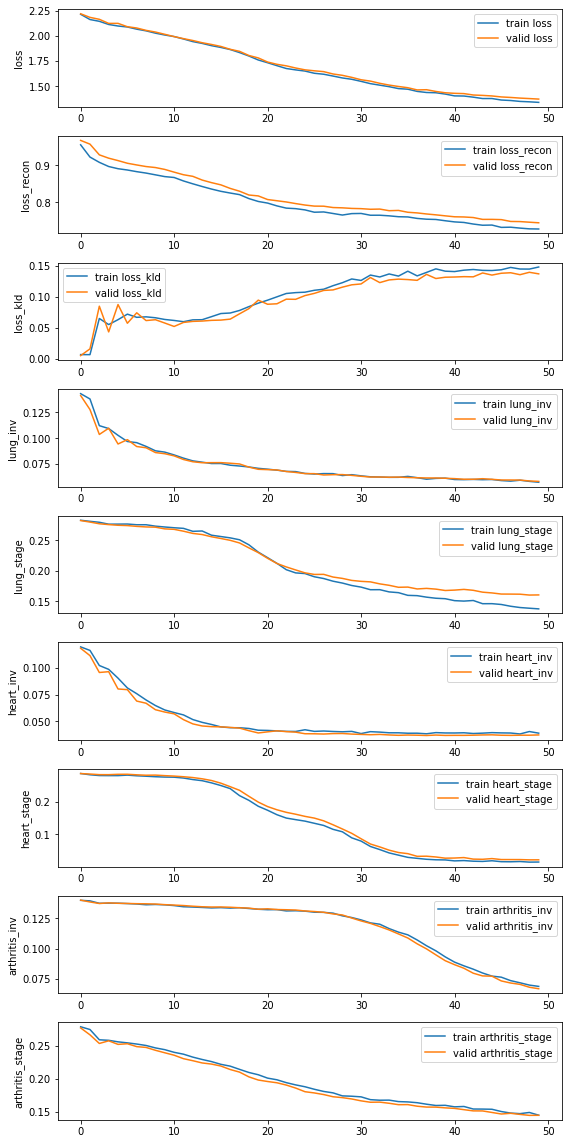

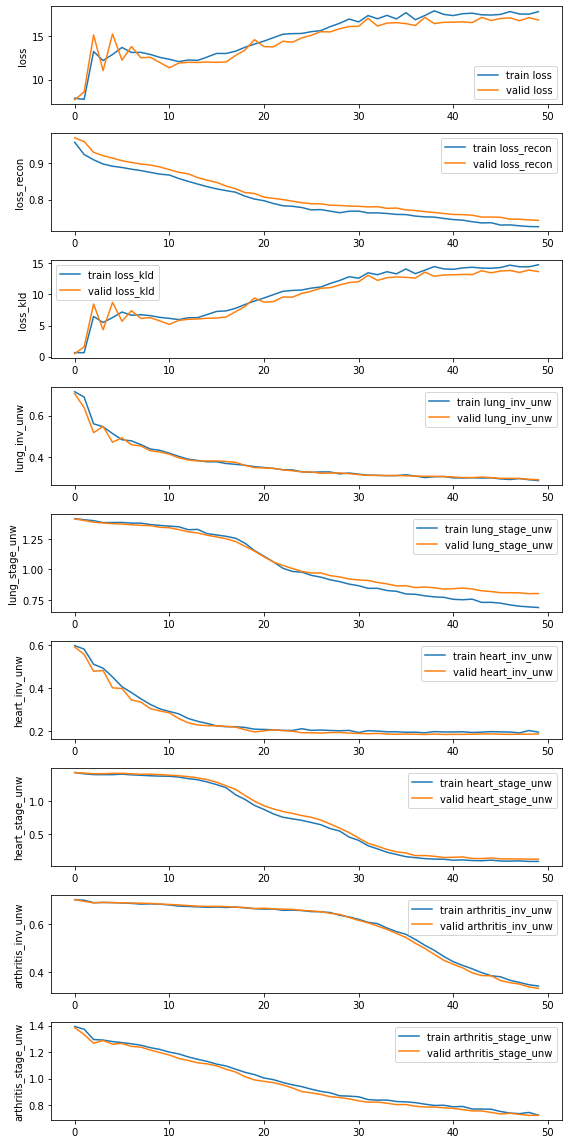

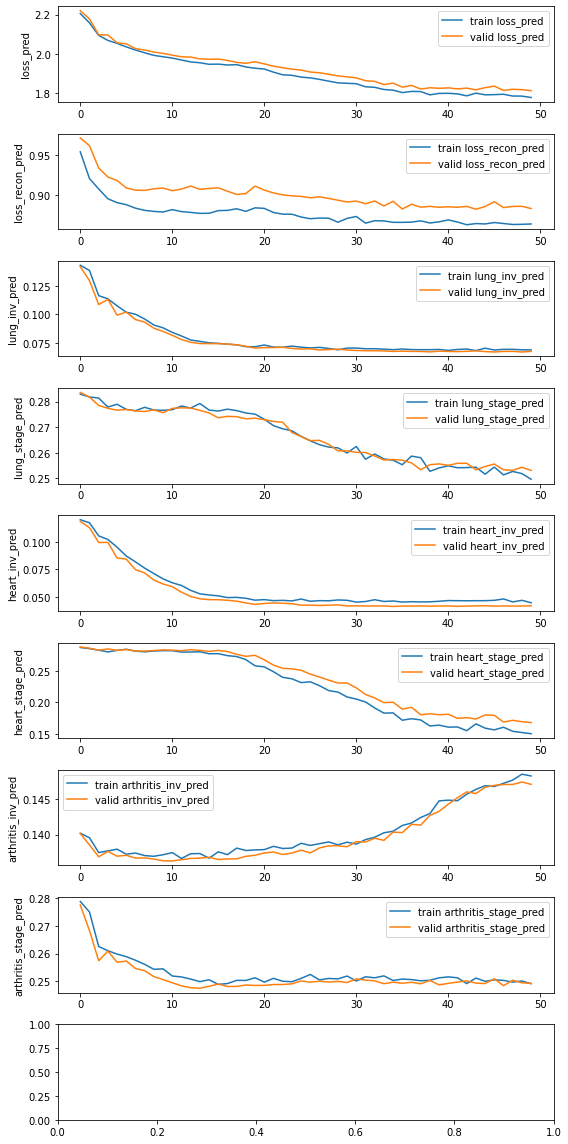

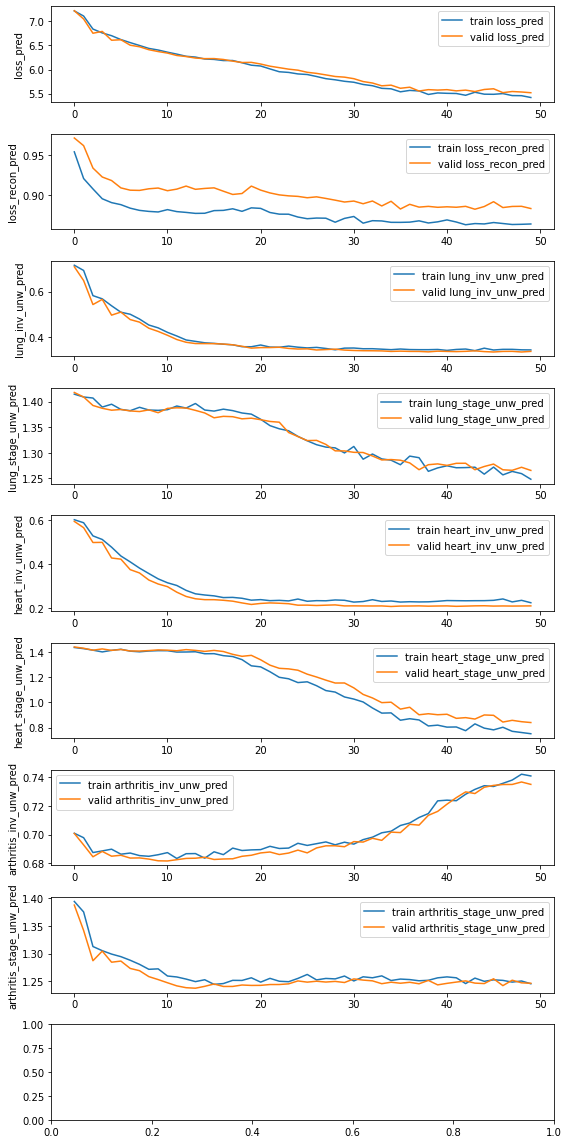

In [4]:
plot_losses(pipeline)